In [1]:
!pip install gdown

!gdown https://drive.google.com/uc?id=10uonevf5ekzr-KCT9w2iQoF9Flnp1c6c

Downloading...
From: https://drive.google.com/uc?id=10uonevf5ekzr-KCT9w2iQoF9Flnp1c6c
To: /content/base_postgrado_v2.csv
100% 2.24M/2.24M [00:00<00:00, 34.9MB/s]


In [2]:
#Importación de librerias

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

data = pd.read_csv("/content/base_postgrado_v2.csv")

In [3]:
data.shape

(13985, 16)

In [4]:
data.head(2)

,id,genero,idgenero,año_ingreso,semestre_trimestre,idprograma,programa,facultad,campus,sede,jornada,duracionprograma,añooportuno,estadoalumno,idestadoalumno,tipoprograma
0,1,Mujer,0,2014,1,IPPG15349,MBA con Especialización en Salud,IPPG,REP,Santiago,Diurna,4,2016,Desertor,0,Magíster
1,2,Mujer,0,2014,1,UNAB25434,Magister en Terapia Ocupacional con Menciones,Ciencias de la Rehabilitación,CAS,Santiago,Vespertina,3,2016,Desertor,0,Magíster


# 4. Descripción de los desafíos

In [5]:
#@title Contar duracción del programa
data['duracionprograma'].value_counts()

4     11752
3      1167
26      545
28      403
2       118
Name: duracionprograma, dtype: int64

In [6]:
data.shape

(13985, 16)

In [7]:
 # Datos outliers
cond1 = data['duracionprograma'] == 26
cond2 = data['duracionprograma'] == 28
data = data[~cond1 & ~cond2]

In [8]:
data.shape

(13037, 16)

In [9]:
#@title Cuenta Activos y Desertores
data['estadoalumno'].value_counts()

Desertor    8641
Activo      4396
Name: estadoalumno, dtype: int64

In [10]:
#@title Conversión de columnas categóricas en numéricas

columns = ['genero',          
           'semestre_trimestre',
           'programa',
           'facultad',
           'campus',
           'sede',
           'jornada',
           'duracionprograma',       
           'estadoalumno',         
           'año_ingreso']

for col in columns:
    if col == 'estadoalumno':
        data['estadoalumno_num'] = data[col].astype("category").cat.codes
        continue
    data[col] = data[col].astype("category").cat.codes
columns.append('estadoalumno_num')
data = data[columns]

In [11]:
data.head(3)

,genero,semestre_trimestre,programa,facultad,campus,sede,jornada,duracionprograma,estadoalumno,año_ingreso,estadoalumno_num
0,1,0,0,6,7,1,0,2,Desertor,0,1
1,1,0,17,1,2,1,2,1,Desertor,0,1
2,0,0,10,4,8,2,2,2,Activo,4,0


In [12]:
#@title 80% Entrenamiento - 20% Test
data_train, data_test = train_test_split(data, test_size=0.2) # data entrenamient y testeo
print("No Sampled, Train: ", data_train.shape, "| Test: ", data_test.shape)

No Sampled, Train:  (10429, 11) | Test:  (2608, 11)


In [13]:
#@title Cuenta Activos y Desertores en el Entrenamiento (80%)
data_train['estadoalumno'].value_counts()

Desertor    6936
Activo      3493
Name: estadoalumno, dtype: int64

In [14]:
#@title Desequilibrio del dataset
activos = data_train[data_train['estadoalumno'] == 'Activo']
desertores = data_train[data_train['estadoalumno'] == 'Desertor'].sample(n=len(activos))
data_train = pd.concat([desertores, activos])

print("Sampled, TRAIN: ", data_train.shape, "| test: ", data_test.shape)

Sampled, TRAIN:  (6986, 11) | test:  (2608, 11)


In [15]:
#@title Nuevo total de Activos y Desertores en el Entrenamiento (80%)
data_train['estadoalumno'].value_counts()

Desertor    3493
Activo      3493
Name: estadoalumno, dtype: int64

# 3. Presentación del Experimento

In [16]:
x_train = data_train.drop(labels=['estadoalumno_num', 'estadoalumno'], axis=1)
y_train = data_train['estadoalumno_num']

x_test = data_test.drop(labels=['estadoalumno_num', 'estadoalumno'], axis=1)
y_test = data_test['estadoalumno_num']

# Entrenamientos de los modelos

* Decision tree
* Random Forest
* SVM

In [17]:
# definicion de la funcion para evaluar los modelos
def mt_conf(y_true, y_pred, x_test, model):
    plt.figure(figsize=(12, 7))
    plot_confusion_matrix(model, x_test, y_test)
    #plt.title(string, fontsize='15')
    plt.show()
    
    return round(100*accuracy_score(y_true, y_pred), 3)

In [18]:
def evaluar_predicciones(y_true, y_pred):
    string = "La precision del modelo es: {}%".format(100*accuracy_score(y_true, y_pred))
    mtf = confusion_matrix(y_true, y_pred)
    print(string, end='\n \n')
    print(classification_report(y_true, y_pred))
    return mtf

In [19]:
#@title Selección Hiperparametros Decision tree

parameters = {
    'criterion': ["gini", "entropy"],
    'splitter':['best', 'random'],
    'max_depth' : range(1, 5),
    'max_features': ['auto', 'sqrt', 'log2', None]
              }
clf_desicion_tree = DecisionTreeClassifier()
searcher = GridSearchCV(clf_desicion_tree, parameters)
searcher.fit(x_train, y_train)
searcher.best_params_

{'criterion': 'gini', 'max_depth': 4, 'max_features': None, 'splitter': 'best'}

La precision del modelo es: 99.96165644171779%
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00      1705

    accuracy                           1.00      2608
   macro avg       1.00      1.00      1.00      2608
weighted avg       1.00      1.00      1.00      2608



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 864x504 with 0 Axes>

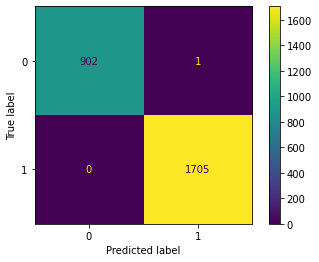

In [20]:
#@title Decision tree
clf_desicion_tree = DecisionTreeClassifier(**searcher.best_params_)
clf_desicion_tree.fit(x_train, y_train)
y_pred = clf_desicion_tree.predict(x_test)

evaluar_predicciones(y_test, y_pred)

resultados_desicion_tree = mt_conf(y_test, y_pred, x_test, clf_desicion_tree)

In [21]:
#@title Selección Hiperparametros Radom Forest
parameters = {
    'criterion': ["gini", "entropy"],
    'max_depth' : range(1, 5),
    'max_features': ['auto', 'sqrt', 'log2', None]
              }

clf_desicion_rf = RandomForestClassifier()
searcher = GridSearchCV(clf_desicion_rf, parameters)
searcher.fit(x_train, y_train)

searcher.best_params_

{'criterion': 'gini', 'max_depth': 4, 'max_features': None}

La precision del modelo es: 99.96165644171779%
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00      1705

    accuracy                           1.00      2608
   macro avg       1.00      1.00      1.00      2608
weighted avg       1.00      1.00      1.00      2608



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 864x504 with 0 Axes>

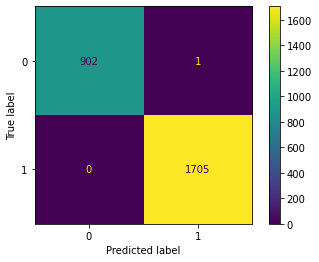

In [22]:
#@title Random Forest
clf_random_forest = RandomForestClassifier(**searcher.best_params_)
clf_random_forest.fit(x_train, y_train)
y_pred = clf_random_forest.predict(x_test)

evaluar_predicciones(y_test, y_pred)

resultados_random_forest = mt_conf(y_test, y_pred, x_test, clf_random_forest)

In [23]:
#@title Selección Hiperparametros SVM
parameters = {
    'kernel':('linear', 'rbf'),
    'C':[1, 10],
    'gamma': ['scale', 'auto'],
    'shrinking': [True, False],
    'decision_function_shape': ['ovo', 'ovr'],
             }

clf_svm = SVC()
searcher = GridSearchCV(clf_svm, parameters)
searcher.fit(x_train, y_train)
searcher.best_params_

{'C': 10,
 'decision_function_shape': 'ovo',
 'gamma': 'auto',
 'kernel': 'rbf',
 'shrinking': True}

La precision del modelo es: 100.0%
 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       903
           1       1.00      1.00      1.00      1705

    accuracy                           1.00      2608
   macro avg       1.00      1.00      1.00      2608
weighted avg       1.00      1.00      1.00      2608



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 864x504 with 0 Axes>

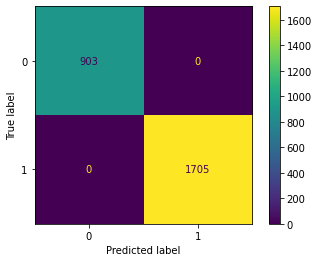

In [24]:
#@title SVM
clf_svm = SVC(**searcher.best_params_)
clf_svm.fit(x_train, y_train)
y_pred = clf_svm.predict(x_test)

evaluar_predicciones(y_test, y_pred)

resultados_svm = mt_conf(y_test, y_pred, x_test, clf_svm)

In [25]:
#@title Resumen de resultados
resultados = {'modelo': ["Descion Tree", "Random Forest", "SVM"],
              'score': [resultados_desicion_tree,
                         resultados_random_forest,
                         resultados_svm]}

res = pd.DataFrame(resultados)
res

,modelo,score
0,Descion Tree,99.962
1,Random Forest,99.962
2,SVM,100.000
